In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Viettel Group (116.102.200.94)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by MobiFone (Can Tho) [129.21 km]: 11.079 ms
Testing download speed................................................................................
Download: 162.87 Mbit/s
Testing upload speed......................................................................................................
Upload: 161.13 Mbit/s


<stdin>:960: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).


# Chuan bi du lieu

In [2]:
import os

BASE_DATA_PATH = r'D:\30VNFoods-main\Images' 

TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'Train')
VALIDATE_PATH = os.path.join(BASE_DATA_PATH, 'Validate')
TEST_PATH = os.path.join(BASE_DATA_PATH, 'Test')

if os.path.exists(TRAIN_PATH):
    classes = os.listdir(TRAIN_PATH)
    print(f"Số lượng món ăn: {len(classes)}")
else:
    print("Không tìm thấy thư mục!")

Số lượng món ăn: 40


# Đường dẫn lưu dữ

In [3]:
PATH = 'Models/InceptionV3'

# --- PHẦN BASE MODEL ---
BASE_MODEL_BEST = os.path.join(PATH, 'base_model_best.h5') 
BASE_MODEL_TRAINED = os.path.join(PATH, 'base_model_trained.h5') 
BASE_MODEL_FIG = os.path.join(PATH, 'base_model_fig.jpg')

# --- PHẦN FINE-TUNE MODEL ---
FINE_TUNE_MODEL_BEST = os.path.join(PATH, 'fine_tune_model_best.h5')
FINE_TUNE_MODEL_TRAINED = os.path.join(PATH, 'fine_tune_model_trained.h5')
FINE_TUNE_MODE_FIG = os.path.join(PATH, 'fine_tune_model_fig.jpg')

In [4]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
generated_train_data = train_datagen.flow_from_directory(
    TRAIN_PATH, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

generated_validate_data = validate_datagen.flow_from_directory(
    VALIDATE_PATH, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

generated_test_data = test_datagen.flow_from_directory(
    TEST_PATH, 
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 20455 images belonging to 40 classes.
Found 2875 images belonging to 40 classes.
Found 5404 images belonging to 40 classes.


# Huấn luyện


In [7]:
CLASSES = 40
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 249

In [8]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(300, 300, 3) 
)

base_model.trainable = False

print(" Đã khởi tạo InceptionV3 với input (300, 300, 3)")

 Đã khởi tạo InceptionV3 với input (300, 300, 3)


# Định nghĩa mô hình

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [10]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

## Hàm gọi lại


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_checkpointer = ModelCheckpoint(
    filepath = BASE_MODEL_BEST, 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = FINE_TUNE_MODEL_BEST, 
    save_best_only = True,
    verbose = 1, 
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

## Giai đoạn 1: Học chuyển giao

In [12]:
for layer in pretrained_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    callbacks = [base_checkpointer, early_stopping],
    epochs = INITIAL_EPOCHS,
    verbose = 1,
)
model.save(BASE_MODEL_TRAINED)

Epoch 1/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2591 - loss: 2.8628
Epoch 1: val_loss improved from None to 1.60321, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1480s 5s/step - accuracy: 0.3654 - loss: 2.2791 - val_accuracy: 0.5327 - val_loss: 1.6032
Epoch 2/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 16:12 3s/step - accuracy: 0.3906 - loss: 2.1037

d:\30VNFoods-main\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.60321
319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 441ms/step - accuracy: 0.3906 - loss: 2.1037 - val_accuracy: 0.4961 - val_loss: 1.6546
Epoch 3/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5172 - loss: 1.6412
Epoch 3: val_loss improved from 1.60321 to 1.34963, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1384s 4s/step - accuracy: 0.5285 - loss: 1.6062 - val_accuracy: 0.6019 - val_loss: 1.3496
Epoch 4/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 15:58 3s/step - accuracy: 0.5156 - loss: 1.4692
Epoch 4: val_loss did not improve from 1.34963
319/319 ━━━━━━━━━━━━━━━━━━━━ 146s 449ms/step - accuracy: 0.5156 - loss: 1.4692 - val_accuracy: 0.5593 - val_loss: 1.4762
Epoch 5/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5586 - loss: 1.4767
Epoch 5: val_loss improved from 1.34963 to 1.30869, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1319s 4s/step - accuracy: 0.5676 - loss: 1.4544 - val_accuracy: 0.6140 - val_loss: 1.3087
Epoch 6/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 15:47 3s/step - accuracy: 0.5312 - loss: 1.5634
Epoch 6: val_loss improved from 1.30869 to 1.28165, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.5312 - loss: 1.5634 - val_accuracy: 0.6197 - val_loss: 1.2817
Epoch 7/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5943 - loss: 1.3502
Epoch 7: val_loss improved from 1.28165 to 1.19729, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1300s 4s/step - accuracy: 0.5956 - loss: 1.3569 - val_accuracy: 0.6467 - val_loss: 1.1973
Epoch 8/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 17:49 3s/step - accuracy: 0.5625 - loss: 1.4818
Epoch 8: val_loss did not improve from 1.19729
319/319 ━━━━━━━━━━━━━━━━━━━━ 145s 446ms/step - accuracy: 0.5625 - loss: 1.4818 - val_accuracy: 0.6520 - val_loss: 1.1994
Epoch 9/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6094 - loss: 1.2953
Epoch 9: val_loss did not improve from 1.19729
319/319 ━━━━━━━━━━━━━━━━━━━━ 1431s 4s/step - accuracy: 0.6061 - loss: 1.3075 - val_accuracy: 0.6374 - val_loss: 1.2214
Epoch 10/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 15:44 3s/step - accuracy: 0.5781 - loss: 1.3539
Epoch 10: val_loss improved from 1.19729 to 1.18248, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 141s 434ms/step - accuracy: 0.5781 - loss: 1.3539 - val_accuracy: 0.6531 - val_loss: 1.1825
Epoch 11/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6167 - loss: 1.2788
Epoch 11: val_loss improved from 1.18248 to 1.14181, saving model to Models/InceptionV3\base_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1294s 4s/step - accuracy: 0.6172 - loss: 1.2687 - val_accuracy: 0.6705 - val_loss: 1.1418
Epoch 12/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 15:55 3s/step - accuracy: 0.6875 - loss: 1.1162
Epoch 12: val_loss did not improve from 1.14181
319/319 ━━━━━━━━━━━━━━━━━━━━ 140s 431ms/step - accuracy: 0.6875 - loss: 1.1162 - val_accuracy: 0.6566 - val_loss: 1.1651
Epoch 13/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6324 - loss: 1.2241
Epoch 13: val_loss did not improve from 1.14181
319/319 ━━━━━━━━━━━━━━━━━━━━ 1270s 4s/step - accuracy: 0.6295 - loss: 1.2337 - val_accuracy: 0.6641 - val_loss: 1.1641
Epoch 14/15
  1/319 ━━━━━━━━━━━━━━━━━━━━ 16:15 3s/step - accuracy: 0.6562 - loss: 1.1902
Epoch 14: val_loss did not improve from 1.14181
319/319 ━━━━━━━━━━━━━━━━━━━━ 140s 430ms/step - accuracy: 0.6562 - loss: 1.1902 - val_accuracy: 0.6388 - val_loss: 1.2401
Epoch 14: early stopping


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

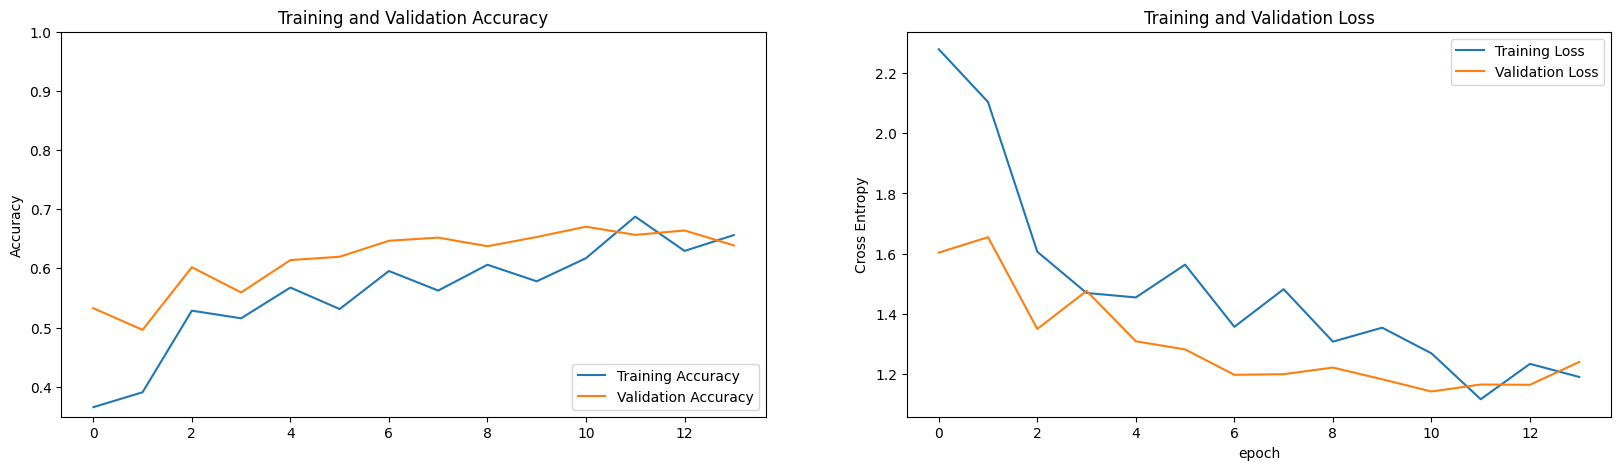

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(BASE_MODEL_FIG)
plt.show()

## Giai đoạn 2: Tinh chỉnh

In [16]:
for layer in pretrained_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

for layer in pretrained_model.layers[FINE_TUNE_AT:]:
    layer.trainable = True

In [17]:
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [18]:
history_fine = model.fit(
    generated_train_data,
    validation_data = generated_validate_data,
    validation_steps = generated_validate_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n // BATCH_SIZE,
    epochs = TOTAL_EPOCHS,
    initial_epoch = history.epoch[-1],
    callbacks = [fine_tune_checkpointer, early_stopping],
    verbose = 1,
)
model.save(FINE_TUNE_MODEL_TRAINED)

Epoch 14/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4474 - loss: 2.0154
Epoch 14: val_loss improved from None to 1.16725, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1588s 5s/step - accuracy: 0.5386 - loss: 1.6110 - val_accuracy: 0.6644 - val_loss: 1.1672
Epoch 15/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 21:49 4s/step - accuracy: 0.5156 - loss: 1.4928

d:\30VNFoods-main\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 15: val_loss improved from 1.16725 to 1.16497, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 144s 439ms/step - accuracy: 0.5156 - loss: 1.4928 - val_accuracy: 0.6655 - val_loss: 1.1650
Epoch 16/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6267 - loss: 1.2517
Epoch 16: val_loss improved from 1.16497 to 1.09122, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1560s 5s/step - accuracy: 0.6374 - loss: 1.2115 - val_accuracy: 0.6850 - val_loss: 1.0912
Epoch 17/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 21:08 4s/step - accuracy: 0.6250 - loss: 1.2947
Epoch 17: val_loss did not improve from 1.09122
319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.6250 - loss: 1.2947 - val_accuracy: 0.6818 - val_loss: 1.0923
Epoch 18/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6574 - loss: 1.1186
Epoch 18: val_loss improved from 1.09122 to 1.04185, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1497s 5s/step - accuracy: 0.6615 - loss: 1.1129 - val_accuracy: 0.6985 - val_loss: 1.0419
Epoch 19/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 20:20 4s/step - accuracy: 0.7500 - loss: 0.7233
Epoch 19: val_loss did not improve from 1.04185
319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.7500 - loss: 0.7233 - val_accuracy: 0.6964 - val_loss: 1.0464
Epoch 20/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6791 - loss: 1.0569
Epoch 20: val_loss improved from 1.04185 to 1.01425, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1495s 5s/step - accuracy: 0.6839 - loss: 1.0514 - val_accuracy: 0.7067 - val_loss: 1.0142
Epoch 21/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 20:41 4s/step - accuracy: 0.7344 - loss: 0.8856
Epoch 21: val_loss improved from 1.01425 to 1.01406, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.7344 - loss: 0.8856 - val_accuracy: 0.7045 - val_loss: 1.0141
Epoch 22/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6913 - loss: 1.0200
Epoch 22: val_loss improved from 1.01406 to 0.98737, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1489s 5s/step - accuracy: 0.6948 - loss: 1.0065 - val_accuracy: 0.7159 - val_loss: 0.9874
Epoch 23/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 20:20 4s/step - accuracy: 0.7344 - loss: 0.9103
Epoch 23: val_loss improved from 0.98737 to 0.98530, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.7344 - loss: 0.9103 - val_accuracy: 0.7159 - val_loss: 0.9853
Epoch 24/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7075 - loss: 0.9640
Epoch 24: val_loss improved from 0.98530 to 0.96440, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1533s 5s/step - accuracy: 0.7058 - loss: 0.9694 - val_accuracy: 0.7227 - val_loss: 0.9644
Epoch 25/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 20:58 4s/step - accuracy: 0.6562 - loss: 1.0433
Epoch 25: val_loss improved from 0.96440 to 0.96127, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 438ms/step - accuracy: 0.6562 - loss: 1.0433 - val_accuracy: 0.7216 - val_loss: 0.9613
Epoch 26/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7154 - loss: 0.9370
Epoch 26: val_loss improved from 0.96127 to 0.95113, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1537s 5s/step - accuracy: 0.7166 - loss: 0.9327 - val_accuracy: 0.7266 - val_loss: 0.9511
Epoch 27/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 21:13 4s/step - accuracy: 0.6250 - loss: 1.0492
Epoch 27: val_loss improved from 0.95113 to 0.94715, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 145s 445ms/step - accuracy: 0.6250 - loss: 1.0492 - val_accuracy: 0.7262 - val_loss: 0.9471
Epoch 28/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7195 - loss: 0.9227
Epoch 28: val_loss improved from 0.94715 to 0.93437, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1539s 5s/step - accuracy: 0.7238 - loss: 0.9151 - val_accuracy: 0.7333 - val_loss: 0.9344
Epoch 29/30
  1/319 ━━━━━━━━━━━━━━━━━━━━ 13:03 2s/step - accuracy: 0.7179 - loss: 0.6900
Epoch 29: val_loss improved from 0.93437 to 0.92713, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 442ms/step - accuracy: 0.7179 - loss: 0.6900 - val_accuracy: 0.7362 - val_loss: 0.9271
Epoch 30/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7297 - loss: 0.8832
Epoch 30: val_loss improved from 0.92713 to 0.91959, saving model to Models/InceptionV3\fine_tune_model_best.h5


319/319 ━━━━━━━━━━━━━━━━━━━━ 1573s 5s/step - accuracy: 0.7276 - loss: 0.8859 - val_accuracy: 0.7408 - val_loss: 0.9196


In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

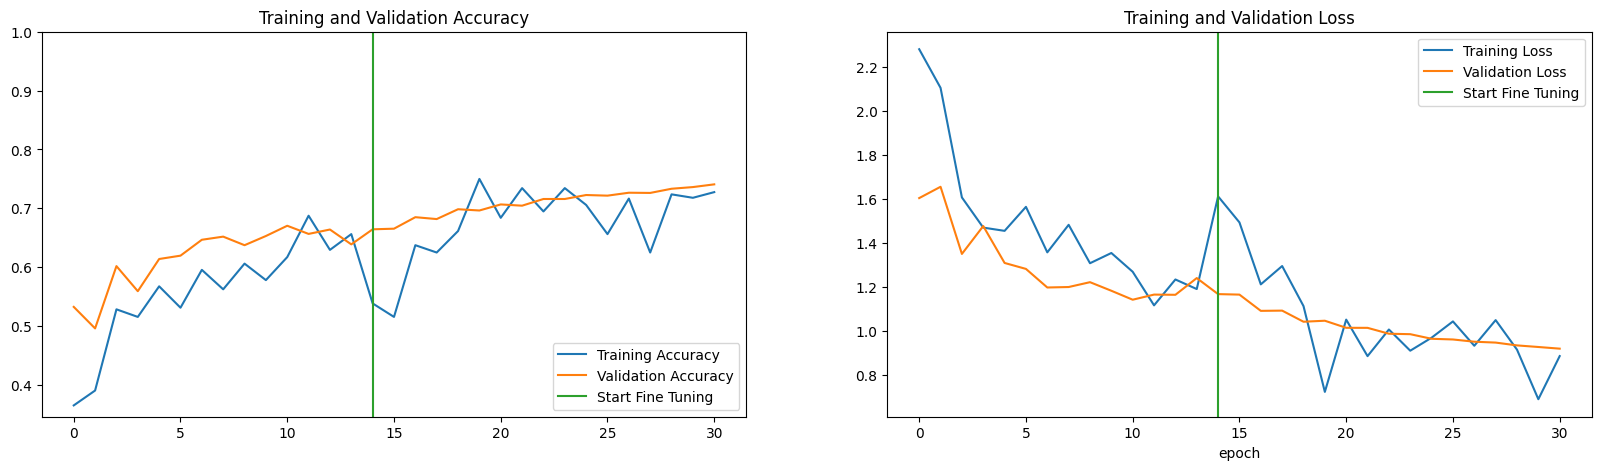

In [20]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([INITIAL_EPOCHS - 1, INITIAL_EPOCHS - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(FINE_TUNE_MODE_FIG)
plt.show()

In [21]:
loss, accuracy = model.evaluate(generated_test_data)
print('Test accuracy:', accuracy)

169/169 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7226 - loss: 0.9189
Test accuracy: 0.7226128578186035


In [22]:
import gc
del model
gc.collect()

8475